#Chapter 6, Example 4

In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Create the figures folder if it doesn't exist
import os
if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

creating the figures folder


In [2]:
# Load and prepare the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Choose 12000 images for training, 2000 images for testing
train_data_subset = torch.utils.data.Subset(train_dataset, range(12000))
test_data_subset = torch.utils.data.Subset(test_dataset, range(2000))

# Use DataLoader to batch and shuffle the dataset
train_dataloader = DataLoader(train_data_subset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data_subset, batch_size=128, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 186365459.41it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44113508.31it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 70380723.32it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4256150.31it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Build Model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding='same')  # Same padding
        self.p1 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.conv2 = nn.Conv2d(32, 64, 5, padding='same')  # Same padding
        self.p2 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.flatten = nn.Flatten()
        self.d1 = nn.Linear(7 * 7 * 64, 1024)
        self.dropout = nn.Dropout(0.2)
        self.d2 = nn.Linear(1024, 10)

    def forward(self, x):
        conv1 = torch.relu(self.conv1(x))
        p1 = self.p1(conv1)
        conv2 = torch.relu(self.conv2(p1))
        p2 = self.p2(conv2)
        flatten = self.flatten(p2)
        d1 = torch.relu(self.d1(flatten))
        dropout = self.dropout(d1)
        out = torch.softmax(self.d2(dropout), dim=1)
        return conv1, p1, conv2, p2, out


# Create an instance of the model
model = MyModel()

Training with: SGD...
Epoch 1, Loss: 2.3026813167206783, Accuracy: 0.06848404255319149, Test Loss: 2.3028144240379333, Test Accuracy: 0.07167968759313226
Epoch 2, Loss: 2.3026261989106525, Accuracy: 0.0733876329787234, Test Loss: 2.3027257323265076, Test Accuracy: 0.07539062504656613
Epoch 3, Loss: 2.302580531607283, Accuracy: 0.07837433510638298, Test Loss: 2.302701786160469, Test Accuracy: 0.07568359375
Epoch 4, Loss: 2.302528848039343, Accuracy: 0.08178191489361702, Test Loss: 2.302677184343338, Test Accuracy: 0.08085937518626451
Epoch 5, Loss: 2.302486541423392, Accuracy: 0.0818927304700334, Test Loss: 2.302633658051491, Test Accuracy: 0.09160156268626451
Epoch 6, Loss: 2.3024177170814353, Accuracy: 0.09103501770407596, Test Loss: 2.3025602996349335, Test Accuracy: 0.09482421865686774
Epoch 7, Loss: 2.302374707891586, Accuracy: 0.09640957446808511, Test Loss: 2.302522510290146, Test Accuracy: 0.08769531268626451
Epoch 8, Loss: 2.302333032831233, Accuracy: 0.10411125881240722, Test 

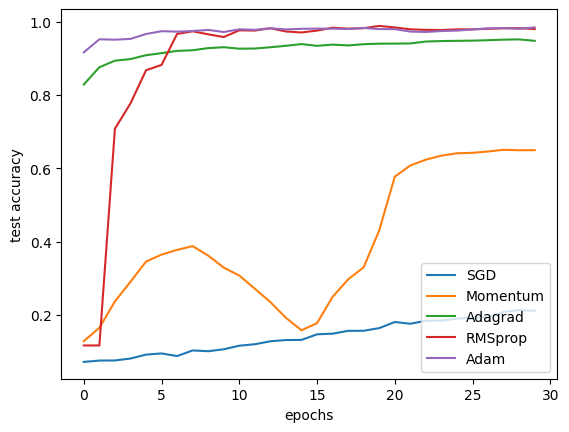

In [4]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Choose a loss function for training
loss_object = nn.CrossEntropyLoss()

# Train step
def train_step(images, labels, optimizer):
    optimizer.zero_grad()
    _,_,_,_,predictions = model(images)
    loss = loss_object(predictions, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), (predictions.argmax(dim=1) == labels).type(torch.float).mean().item()

# Test step
def test_step(images, labels):
    _,_,_,_,predictions = model(images)
    t_loss = loss_object(predictions, labels)
    return t_loss.item(), (predictions.argmax(dim=1) == labels).type(torch.float).mean().item()

# Main function: train and test the model
EPOCHS = 30
plt.figure()
for myoptimizer in ['SGD', 'Momentum', 'Adagrad', 'RMSprop', 'Adam']:
    # Create an instance of the model
    model = MyModel()
    print('Training with: '+myoptimizer+'...')
    if myoptimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    elif myoptimizer == 'Momentum':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    elif myoptimizer == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3)
    elif myoptimizer == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    elif myoptimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    else:
        print("Wrong optimizer type")
        continue

    test_acc = []
    for epoch in range(EPOCHS):
        train_loss = 0.0
        train_accuracy = 0.0
        test_loss = 0.0
        test_accuracy = 0.0
        train_steps = 0
        test_steps = 0

        for images, labels in train_dataloader:
            l, a = train_step(images, labels, optimizer)
            train_loss += l
            train_accuracy += a
            train_steps += 1

        with torch.no_grad():
            for test_images, test_labels in test_dataloader:
                t_l, t_a = test_step(test_images, test_labels)
                test_loss += t_l
                test_accuracy += t_a
                test_steps += 1

        test_acc.append(test_accuracy / test_steps)
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print(template.format(epoch + 1,
                              train_loss / train_steps,
                              train_accuracy / train_steps,
                              test_loss / test_steps,
                              test_accuracy / test_steps))

    plt.plot(np.arange(EPOCHS), test_acc, label=myoptimizer)

plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.legend(loc='lower right')
plt.savefig('./figures/6.4_1.png')